In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import *

## 2 - Etude et résolution numérique

#### On s’intéresse dans un premier temps au cas d’un seul véhicule.

#### 1. Etudier le problème (convexité, conditionnement, existence et unicité d’une solution) par la méthode, analytique ou numérique, de votre choix. Proposer une méthode de résolution adaptée aux caractéristiques du problème.


Si on reprend les équations (2a) à (2d) de la modélisation en les appliquand au cas d'une seule voiture (l'ensemble de vecteur $w_{i}$ devient simplement $w$ un vecteur de $\mathbb{R}^{N}_{+}$ , etc.) on obtient le problème de minimisation suivant :

$\underset{w \in \mathbb{R}^{N}_{+}}{\min} f(w) = p^{T}.w$

$c_{1}(w) = b_{0} 1^{T} w - \Delta q$

$c_{2}(w) = -w $

$c_{3}(w) = w - w_{max} $


Comme le suggérait l'énoncé, toutes les composantes de $p$ étant positives on se place directement dans l'interval temporel {$n_{0}$, $n_{f}$} qui correspond aux instants discrétisés consécutifs où la voiture est en charge. La contrainte 1 somme donc toutes les puissances employées pendant chaque instant, les divise par la tension et doit égaler la différence de charge demandé par le consomateur. On pose donc $n_{0} = 0 $ et $ n_{f} = N $ Ainsi chaque vecteur à $N$ coordonnées.

Les contraintes 2 et 3 s'assurent que la puissance fournie reste positive (pas le droit de décharger la voiture) et ne dépasse pas un maximum.

Il est évident que $f$ et toutes les contraintes sont convexes car soit affine soit linéaire. Pour prouver l'existence d'une solution il faut prouver que l'espace engendrée par les 3 contraintes $c_{1} =0$, $c_{2} \le 0$  et $c_{3} \le 0$ soit non vide. Pour cela il suffit que $\frac{\Delta q} {N b_{0}} \leq w_{max} $. Dans ce cas la contrainte 1 est possible. Cela équivaut à dire que l'usager à laisser sa voiture assez longtemps pour qu'elle puisse être chargé au niveau demandé même en utilisant la puissance maximal constamment.

Comme l'ensemble engendré par les contraintes est un fermé borné et que $f$ y est continue (car linéaire sur $\mathbb{R}^{N}$) le théorème de Weierstrauss nous donne l'existence d'une solution. 

Pour la méthode de résolution il suffirait de fournir de la puissance en priorité aux instants où le prix est le plus bas, mais nous choisissons tout de même d'implémenter un algorithme d'Uzawa adapté à ces contraintes affines avec une descente selon l'opposé du gradient. 

On transformera par la suite la contrainte $c_1(w) = 0$ en $-c_1(w) \leq 0$. Ecrit de cette façon cette contrainte augmente la valeur de  w. Or le problème de minimisation cherche à minimiser w on devrait donc retomber dans le cas d'égalité. Nous mettons en place cette pirouette pour pouvoir utiliser l'algorithme d'Uzawa avec seulement des contraintes inégalités.

Il semblerait que $p>0$ permette d'avoir unicité de la solution. 

#### 2. Proposer des ordres de grandeurs pour les variables du problème et développer un algorithme de résolution. Commenter les résultats obtenus.

Pour ce qui est de la discrétisation du temps, nous proposons de choisir $N=300$. Ce choix résulte d'un compromis entre la fidélité avec la variation de la puissance et du cours de l'éléctricité dans la réalité et le coût temporel de la modélisation.

Aussi surprenant que ce soit le premier notebook rendu nous a ammené à la conclusion que la charge maximal d'une batterie était de 535 Coulombs environ ( Dans la réalité il y a bien 3 ordres de grandeurs de différence pour une voiture électrique). Néanmoins à l'aide de cette valeur on peut rammener $q_{i}$ à une valeur adimensionnelle comprise entre 0 et 1 en prenant en compte $q_{max}$ dans $b_{0}$.

Pour $b_{0}$ on choisit de se baser sur la tension réseau qui vaut 230V ainsi que $q_{max}$ pour étudier des niveaux de charges adimensionnés. Ainsi $b_{0} = 8,13.10^{-6} W^{-1}$ Pour un point d'homogénéité, on précise que l'indicatrice est en quelque sorte homogène à une distance.

Pour ce qui est du prix nous aurions pu considérer une répartition aléatoire pour tester plus efficacement l'algorithme mais nous choissisons de simplifier légèrement l'étude en choisissant un prix croissant puis décroissant sur l'intervalle considérée. Pour suivre le cours actuel nous alternerons entre $0.18$ et $0.09$ euros le kWh. Soit entre $5 10^{-8}$ et $2.5 10^{-8}$ euros pour un Watt pendant une seconde. Nous avons conscience que ces valeurs sont très faibles et pourraient poser problème dans la suite de l'algorithme. 

Nous avons le sentiment que deux paliers à prix fixe, bien que certainement le cas dans la réalité, serait sous emplioyé l'algorithme de résolution. 

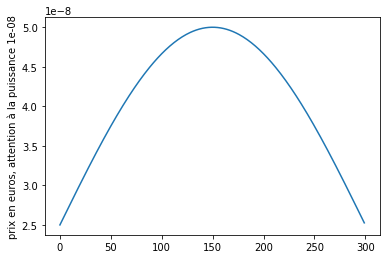

In [2]:
N = 300
indic = [1 for k in range(N)]
b=8.13 * 10**(-6)
p_inf , p_sup  = 2.5 * 10**(-8), 5 * 10 **(-8)
p=[]
for k in range(N):
    p.append(p_inf + (p_sup - p_inf) * np.cos(np.pi*(k-150)/300))
    
plt.plot(p)
plt.ylabel(f"prix en euros, attention à la puissance {10**-8}")
plt.show()


Une fois ces valeurs choisies nous pouvons décider de $w_{max}$ avec la condition évoquée précédement. Considérons une demande de charge maximal avec $\Delta q =1 $

In [3]:
w_normal = 1/(b*N)
w_normal

410.00410004100036

Nous ne sommes donc pas limités si nous choisissons une valeur de $7000 W$ pour $w_{max}$, c'est de l'ordre de grandeur de ce que les stations les plus puissantes aujourd'hui peuvent fournir. 

Ainsi avec cette dernière unité fixé nous pouvons conclure que notre choix de N=300 équivaut à s'intéresser à 5min du système. Au vu de la valeur de $w_{max}$ il sera possible d'aggrandir la largeur d'étude au prix d'un coût de calcul plus important. 

In [4]:
w_max = 7000
w_max_vector = [w_max for k in range(N)]
w_normal_vector = [w_normal for k in range(N)]

In [5]:
def f_p(p,w):
    return np.dot(p,w)
    
prix_max = f_p(p,w_max_vector)
prix_normal = f_p(p,w_normal_vector)

print(f"Au pire du pire on paye {prix_max} euros..")
print(f"même si on s'attend surtout à payer au plus {prix_normal} euros.." )

Au pire du pire on paye 0.08592223261612067 euros..
même si on s'attend surtout à payer au plus 0.00503263823675515 euros..


In [6]:
delta_q = 0.5

def c1(w):
    soc= delta_q - b * np.dot(indic,w)
    return soc

def c2(w): 
    return np.array(-w)

def c3(w):
    return np.array(w-w_max)

def grad_f_p(p):
    return np.array(p)

def grad_c1():
    t=[]
    for k in range(N):
        t.append(-b*indic[k]) ##on conserve la valeur si l'indicatrice est nul
    return np.array(t)

#grad_c1 et grad_c2 ne servent pas car ils s'annuleront toujours étant opposé 
#(et en plus je n'arrive pas a calculer correctement le gradient d'une application à valeur dans R^N).

Nous allons essayer d'implémenter l'algorithme d'Uzawa avec ces paramètres.

[-6699.90952073 -6699.90952073 -6699.90952073 -6699.90952073
 -6699.90952073 -6699.90952073 -6699.90952073 -6699.90952073
 -6699.90952073 -6699.90952073 -6699.90952073 -6699.90952073
 -6699.90952073 -6699.90952073 -6699.90952073 -6699.90952073
 -6699.90952073 -6699.90952073 -6699.90952073 -6699.90952073
 -6699.90952073 -6699.90952073 -6699.90952073 -6699.90952073
 -6699.90952073 -6699.90952073 -6699.90952073 -6699.90952073
 -6699.90952073 -6699.90952073 -6699.90952073 -6699.90952073
 -6699.90952073 -6699.90952073 -6699.90952073 -6699.90952073
 -6699.90952073 -6699.90952073 -6699.90952073 -6699.90952073
 -6699.90952073 -6699.90952073 -6699.90952073 -6699.90952073
 -6699.90952073 -6699.90952073 -6699.90952073 -6699.90952073
 -6699.90952073 -6699.90952073 -6699.90952073 -6699.90952073
 -6699.90952073 -6699.90952073 -6699.90952073 -6699.90952073
 -6699.90952073 -6699.90952073 -6699.90952073 -6699.90952073
 -6699.90952073 -6699.90952073 -6699.90952073 -6699.90952073
 -6699.90952073 -6699.90

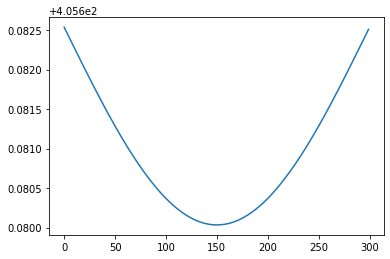

In [12]:
def uzawa(fun, grad_fun, c1, c2, c3, grad_c, x0, l, rho, lambda0, max_iter = 100000, epsilon_grad_L = 10**(-12)):
    k=0
    xk=x0
    lambdak=lambda0
    grad_Lagrangienk_xk = grad_fun(p) + lambdak*grad_c() 
    ##On fait le produit terme à terme de lambda_k par grad_c, je n'ai pas eu d'autres idées.
    #C'est içi qu'on se rend compte que le gradient de c2 et c3 se serait compensé.
        
    while ((k<max_iter) and (np.linalg.norm(grad_Lagrangienk_xk)>epsilon_grad_L)):
        grad_Lagrangienk_xk = grad_fun(p) + lambdak*grad_c()
        pk = -grad_Lagrangienk_xk
        xk = xk + l*pk;        
        lambdak = (lambdak + rho*c1(xk))
        ## içi il y'a surement un problème car prendre en compte 
        ## l'effet de c2 et c3 dans les mêmes coordonnées de lambda
        ## ne permet en rien de traduire les contraintes..
       
        k = k + 1
        
    print(lambdak)
    print(f"le nombre d'itération est {k}")
    return xk

x0 = [440 for k in range(N)]
pas_de_descente = 1
pas_de_montée = 10
lambda0 = [1 for k in range(N)]

result = uzawa(f_p, grad_f_p, c1, c2, c3, grad_c1, x0, pas_de_descente, pas_de_montée, lambda0)

plt.plot(result)


Comme clairement le résultat ne convergait pas en considérant les contraintes 2 et 3, on va essayer sans la 3ème qui au vu de l'amplitude de la pente ne sera jamais atteinte. 

In [10]:
print(b*np.dot(result,indic))
print(c1(result))

0.9894558200039584
-0.4894558200039584


## 3 Etude avancé

#### 3. Etudier la faisabilité d’une méthode de décomposition-coordination (présentée en annexe).

Le problème vient de la contrainte 2d qui ne peut être dissociée puisqu'elle considère la somme d'une coordonnée k de tous les vecteurs décisionnels. On peut essayer de régler le conflit en implémentant l'algo pour deux voitures, en donnant comme contrainte à la première voiture qu'à tout instant w[k]< w_max. Puis en contraignant la deuxième voiture par w_max - w[k] plutôt que par w_max. Cela reviendrait à favoriser une voiture par rapport à l'autre mais au moins elles ne seront pas indépendantes. Il faudrait donc que le contrainte 3 de la deuxième voiture prenne comme variable en entrée la puissance fournie à la première voiture. 

Soyons francs nous n'avons même pas réussi à l'implémenter pour une seule voiture nous n'y arriverons certainement pas pour deux. 

Ce qui nous a posé problème lors de cette étude (et je pense que cela se voit dans notre échec) sont la dimension de la variable dual et les gradients des contraintes 2 et 3 ainsi que la distinction entre les contraintes égalités et inégalités. 
L'algorithme pour une voiture ne converge pas du tout et nous y avons déjà passé beaucoup beaucoup trop de temps pour espèrer le faire marcher, nous en sommes désolé. 